## Importing the Dataset

In [6]:
## Importing the necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score

In [2]:
#Loading the Dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair']=(dta.affairs>0).astype(int)

## Data Exploration and Data Preprocessing

In [3]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


###### Here, we can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the rate_marriage variable.

In [4]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


##### An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

## Data Visualization

C:\Users\tanma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tanma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tanma\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

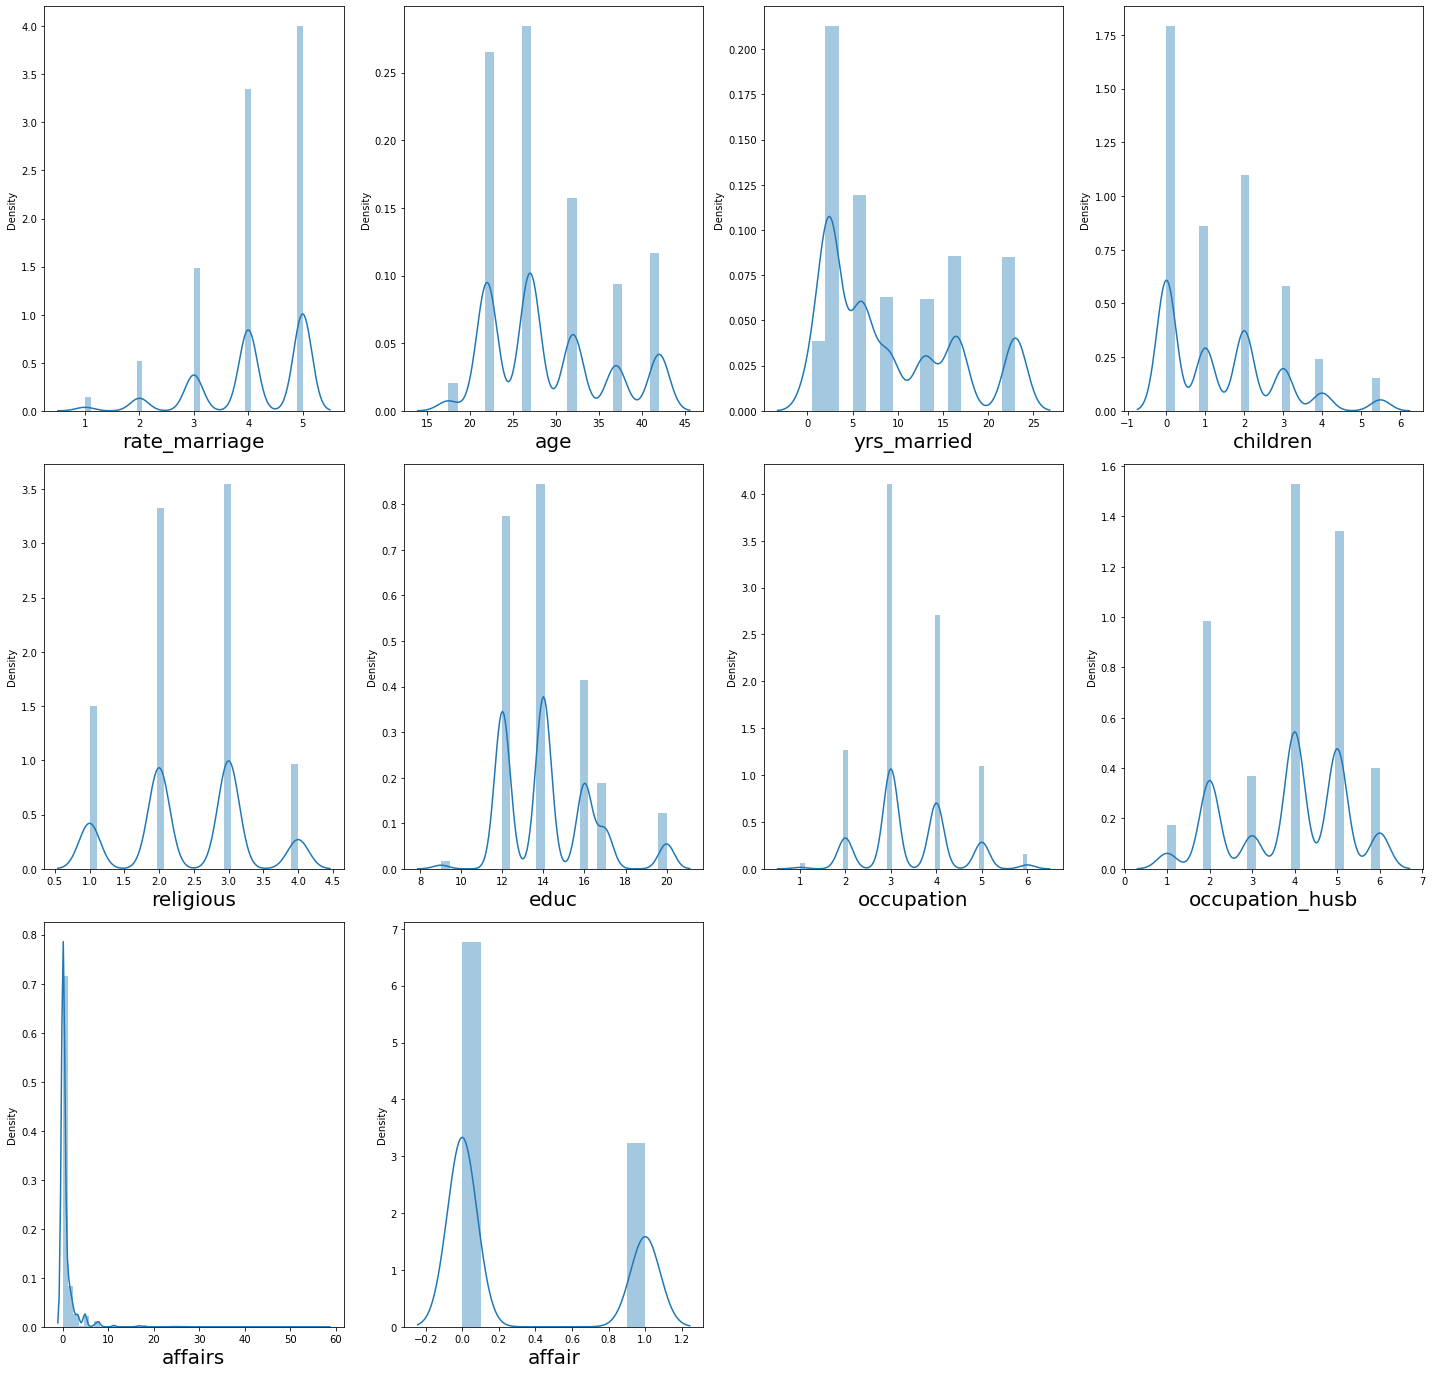

In [8]:
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in dta:
    if plotnumber<=13 :
        ax = plt.subplot(4,4,plotnumber)
        sns.distplot(dta[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

We can see that most of our dataset are normally distributed. So the dataset seems fine.

Text(0, 0.5, 'Frequency')

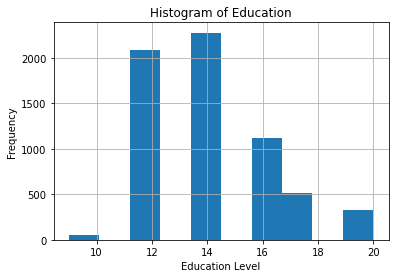

In [9]:
%matplotlib inline
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

In [12]:
#Let us see if there is any correlation between the independent variables
corr=dta.corr()
corr.shape

(10, 10)

<AxesSubplot:>

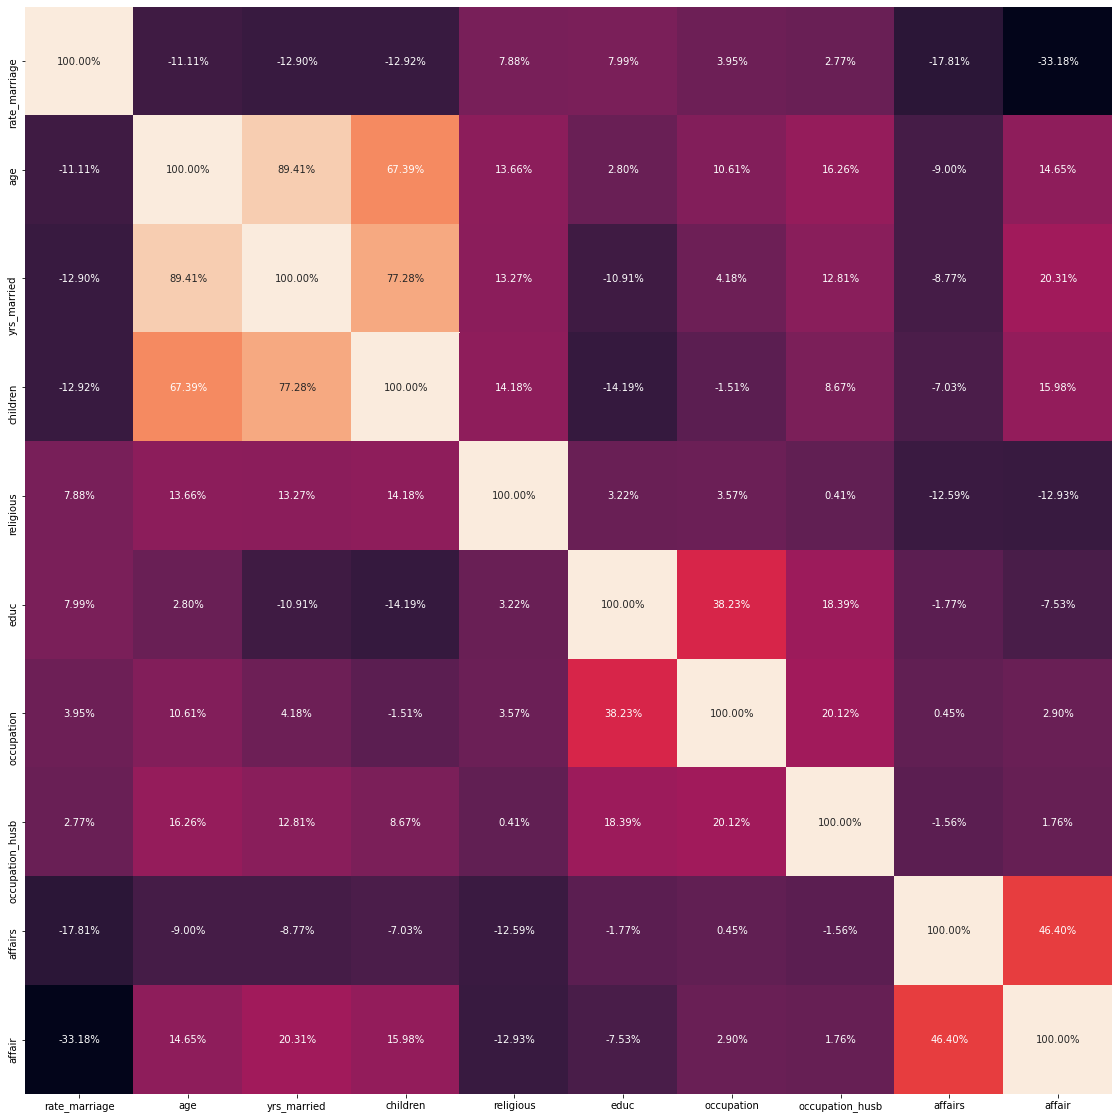

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(corr,cbar=False,square= True, fmt='.2%', annot=True)


Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0, 0.5, 'Percentage')

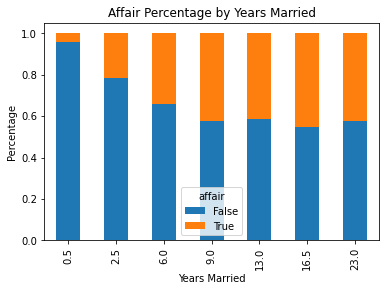

In [10]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')


## Prepare Data for Logistic Regression

We add an intercept column as well as dummy variables for occupation and occupation_husb, since we are treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

In [11]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
# print X.columns

# rename column names for the dummy variables for better looks:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

# and flatten y into a 1-D array so that scikit-learn will properly understand it as the response variable.
y = np.ravel(y)

In [16]:
model=LogisticRegression(max_iter=10000)
model.fit(X,y)

LogisticRegression(max_iter=10000)

In [17]:
# check the accuracy on the training set
model.score(X, y)

0.726358781024191

72% accuracy may seem OK, now let's see the  accuracy if we simply predict no for all observations in the dataset.

In [18]:
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.008682159981245769]
1,occ_2,[0.040895093311020224]
2,occ_3,[0.3524507057479548]
3,occ_4,[0.12148191484795902]
4,occ_5,[0.6990728998510444]
5,occ_6,[0.7340156214513534]
6,occ_husb_2,[0.1469021534908202]
7,occ_husb_3,[0.2553245972084487]
8,occ_husb_4,[0.11905030444732825]
9,occ_husb_5,[0.14944621853866627]


Increases in marriage rating,religiousness and age correspond to a decrease in the likelihood of having an affair.

## Model Evaluation Using a Validation Set

We have only trained and tested the logistic model on the same set. Now we split the data into a training set and a testing set, train the model on the train set and evaluate it on the test set.

In [21]:
#Creating train_test_splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression(max_iter=10000)
model2.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [22]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)


[1. 0. 0. ... 0. 0. 0.]


In [24]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print(probs)

[[0.34778883 0.65221117]
 [0.91179703 0.08820297]
 [0.72755086 0.27244914]
 ...
 [0.56308735 0.43691265]
 [0.81081087 0.18918913]
 [0.75008175 0.24991825]]


We see that the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than **0.5**.



##### Evaluation Metrics

#### Let us evaluate our model using evaluation metrics like roc_auc_curve and confusion matrix

In [26]:
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.7308900523560209
0.7462553150061761


The accuracy is **73.08%**, which is the almost same as we experienced when training and predicting on the same data.

In [28]:
# we can also see the confusion matrix and a classification report with other metrics.
print(metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

[[1168  135]
 [ 379  228]]
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      1303
         1.0       0.63      0.38      0.47       607

    accuracy                           0.73      1910
   macro avg       0.69      0.64      0.64      1910
weighted avg       0.71      0.73      0.71      1910



## Model Evaluation Using Cross-Validation

In [34]:
# evaluating the model using 100-fold cross-validation
scores=cross_val_score(LogisticRegression(max_iter=10000),X,y,scoring='accuracy',cv=100)
print(scores)

[0.703125   0.8125     0.640625   0.6875     0.703125   0.75
 0.71875    0.71875    0.765625   0.671875   0.734375   0.734375
 0.640625   0.703125   0.703125   0.6875     0.703125   0.71875
 0.671875   0.703125   0.796875   0.75       0.734375   0.734375
 0.6875     0.765625   0.65625    0.734375   0.734375   0.75
 0.734375   0.71875    0.71875    0.640625   0.75       0.75
 0.6875     0.65625    0.71875    0.65625    0.703125   0.65625
 0.78125    0.65625    0.734375   0.765625   0.671875   0.734375
 0.671875   0.65625    0.703125   0.640625   0.71875    0.75
 0.796875   0.65625    0.796875   0.765625   0.78125    0.75
 0.71875    0.734375   0.75       0.71875    0.71875    0.8125
 0.76190476 0.71428571 0.73015873 0.71428571 0.68253968 0.74603175
 0.73015873 0.73015873 0.74603175 0.65079365 0.6984127  0.6984127
 0.68253968 0.73015873 0.66666667 0.76190476 0.80952381 0.68253968
 0.76190476 0.76190476 0.77777778 0.74603175 0.76190476 0.84126984
 0.79365079 0.74603175 0.6984127  0.761904

In [35]:
print(scores.mean())

0.7246999007936509


Still our accuracy hasn't changed much. It is **72.46%**.